In [29]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

In [30]:
# Data Collection
file_path = 'temperatures.csv'
data = pd.read_csv(file_path)



In [31]:
# Data Wrangling
print("\nNull Values:\n", data.isnull().sum())


Null Values:
 YEAR       0
JAN        0
FEB        0
MAR        0
APR        0
MAY        0
JUN        0
JUL        0
AUG        0
SEP        0
OCT        0
NOV        0
DEC        0
ANNUAL     0
JAN-FEB    0
MAR-MAY    0
JUN-SEP    0
OCT-DEC    0
dtype: int64


In [32]:
# Check data types
print("\nData Types:\n", data.dtypes)


Data Types:
 YEAR         int64
JAN        float64
FEB        float64
MAR        float64
APR        float64
MAY        float64
JUN        float64
JUL        float64
AUG        float64
SEP        float64
OCT        float64
NOV        float64
DEC        float64
ANNUAL     float64
JAN-FEB    float64
MAR-MAY    float64
JUN-SEP    float64
OCT-DEC    float64
dtype: object


In [33]:
# Remove rows with null values
data_cleaned = data

# Show the cleaned data
print("\nData after removing null values:\n", data_cleaned.head())


Data after removing null values:
    YEAR    JAN    FEB    MAR    APR    MAY    JUN    JUL    AUG    SEP    OCT  \
0  1901  22.40  24.14  29.07  31.91  33.41  33.18  31.21  30.39  30.47  29.97   
1  1902  24.93  26.58  29.77  31.78  33.73  32.91  30.92  30.73  29.80  29.12   
2  1903  23.44  25.03  27.83  31.39  32.91  33.00  31.34  29.98  29.85  29.04   
3  1904  22.50  24.73  28.21  32.02  32.64  32.07  30.36  30.09  30.04  29.20   
4  1905  22.00  22.83  26.68  30.01  33.32  33.25  31.44  30.68  30.12  30.67   

     NOV    DEC  ANNUAL  JAN-FEB  MAR-MAY  JUN-SEP  OCT-DEC  
0  27.31  24.49   28.96    23.27    31.46    31.27    27.25  
1  26.31  24.04   29.22    25.75    31.76    31.09    26.49  
2  26.08  23.65   28.47    24.24    30.71    30.92    26.26  
3  26.36  23.63   28.49    23.62    30.95    30.66    26.40  
4  27.52  23.82   28.30    22.25    30.00    31.33    26.57  


In [34]:
# Extract the columns from JAN to DEC
temperature_data = data_cleaned.loc[:, 'JAN':'DEC']

In [35]:
# Standardize the data
scaler = StandardScaler()
temperature_data_scaled = scaler.fit_transform(temperature_data)

# Perform PCA on the extracted columns
pca = PCA(n_components=1)
pca_result = pca.fit_transform(temperature_data_scaled)

# Add the PCA component to the DataFrame
data_cleaned['PCA1'] = pca_result[:, 0]

In [36]:
data_for_corr = data_cleaned.drop(columns=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'])

# Calculate the correlation matrix between PCA component and other columns
correlation_matrix = data_for_corr.drop(columns=['PCA1']).corrwith(data_cleaned['PCA1']).abs()

# Find the column with the highest and second highest correlation with the PCA component
input_feature_1 = correlation_matrix.idxmax()
correlation_matrix = correlation_matrix.drop(input_feature_1)  # Remove the highest correlated feature
input_feature_2 = correlation_matrix.idxmax()
# Prepare the data for modeling with the highest correlated input feature
X_single = data_cleaned[[input_feature_1]]
y = data_cleaned['PCA1']


In [63]:
round(correlation_matrix, 2)


YEAR       0.80
JAN-FEB    0.80
MAR-MAY    0.81
JUN-SEP    0.86
OCT-DEC    0.92
dtype: float64

In [65]:
best_model = None
min_mse_test = float('inf')
best_X_train = None
best_X_test = None
best_y_train = None
best_y_test = None
best_train_size = None
best_test_size = None
mse_test_values = []
mse_train_values = []

model = LinearRegression()

# Use np.arange to divide the dataset
for train_size in np.arange(0.1, 0.9, 0.1):
    if train_size >= 0.9:
        train_size = 0.9
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_single, y, train_size=train_size, random_state=10)
    
    # Train the Linear Regression model
    
    model.fit(X_train, y_train)
    
    # Predict and calculate metrics for both train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    mse_test = mean_squared_error(y_test, y_test_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_train_values.append(mse_train)
    mse_test_values.append(mse_test) 
    
    # Check if the current model has the minimum test MSE
    if mse_test < min_mse_test:
        min_mse_test = mse_test
        best_model = model
        best_X_train, best_X_test = X_train, X_test
        best_y_train, best_y_test = y_train, y_test
        best_train_size = train_size
        best_test_size = 1 - train_size


In [38]:
# Print the minimum MSE, best train size, and best test size
print(f"Minimum MSE: {round(min_mse_test, 2)}")
print(f"Best Train Size: {round(best_train_size, 2)}")
print(f"Best Test Size: {round(best_test_size, 2)}")

Minimum MSE: 0.09
Best Train Size: 0.8
Best Test Size: 0.2


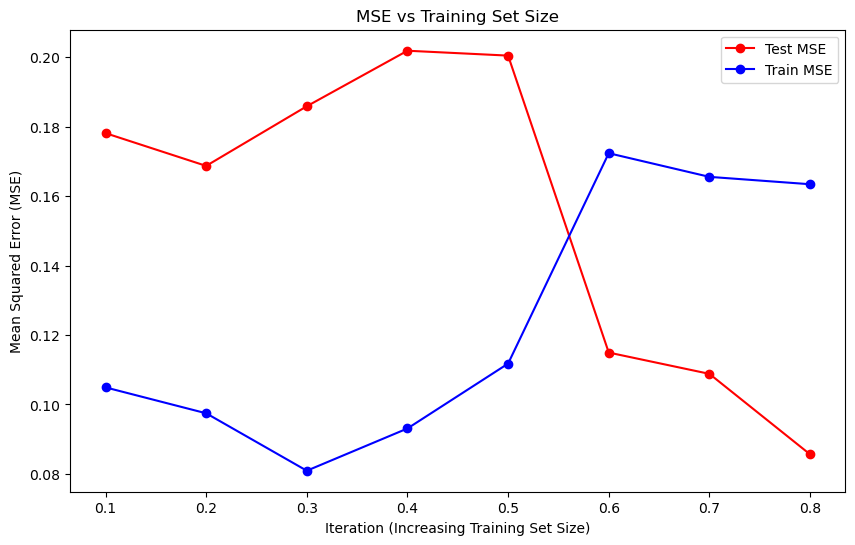

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0.1, 0.9, 0.1), mse_test_values, marker='o', color='red', label='Test MSE')
plt.plot(np.arange(0.1, 0.9, 0.1), mse_train_values, marker='o', color='blue', label='Train MSE')
plt.xlabel('Iteration (Increasing Training Set Size)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Training Set Size')
plt.legend()
plt.show()


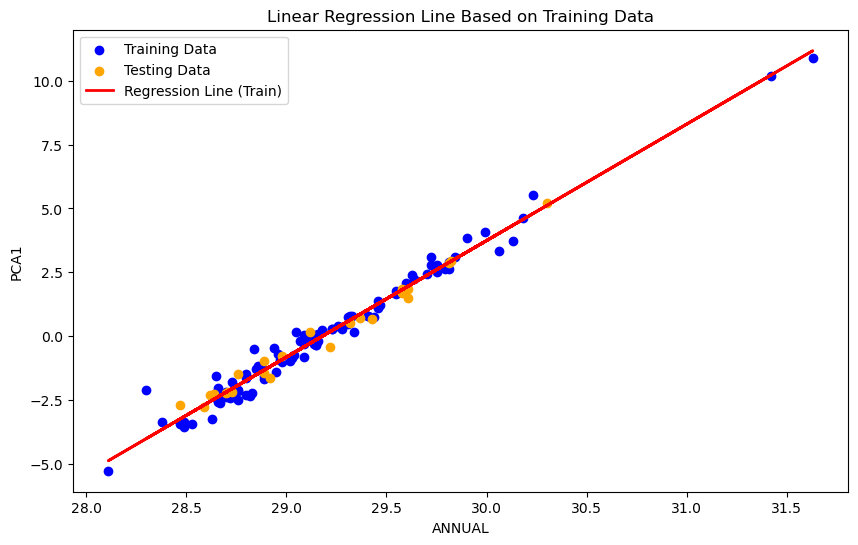

In [40]:
# Train the Linear Regression model on the training data only
model.fit(best_X_train, best_y_train)

# Predict the values using the training and test datasets separately
y_train_pred_full = model.predict(best_X_train)
y_test_pred_full = model.predict(best_X_test)

# Plot the actual vs predicted values based on the training and testing datasets
plt.figure(figsize=(10, 6))
plt.scatter(best_X_train, best_y_train, label="Training Data", color="blue")
plt.scatter(best_X_test, best_y_test, label="Testing Data", color="orange")
plt.plot(best_X_train, y_train_pred_full, label="Regression Line (Train)", color="red", linewidth=2)
plt.xlabel(input_feature_1)
plt.ylabel("PCA1")
plt.title("Linear Regression Line Based on Training Data")
plt.legend()
plt.show()

In [41]:
# Prepare the data for 3D modeling with two input features
X_double = data_cleaned[[input_feature_1, input_feature_2]]

# Split the data for 3D model
X_train_3d, X_test_3d, y_train_3d, y_test_3d = train_test_split(X_double, y, train_size=0.8, random_state=42)

# Train the Linear Regression model using training data only
model.fit(X_train_3d, y_train_3d)

# Create a meshgrid for 3D plotting using the range of training data
x_surf, y_surf = np.meshgrid(np.linspace(X_train_3d[input_feature_1].min(), X_train_3d[input_feature_1].max(), 100),
                             np.linspace(X_train_3d[input_feature_2].min(), X_train_3d[input_feature_2].max(), 100))
z_surf = model.predict(np.array([x_surf.ravel(), y_surf.ravel()]).T)
z_surf = z_surf.reshape(x_surf.shape)

C:\Users\prana\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


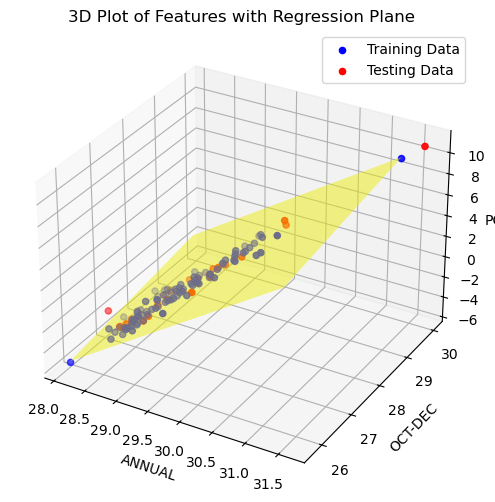

In [42]:






# 3D Plot of the Features with the regression plane
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot training data
ax.scatter(X_train_3d[input_feature_1], X_train_3d[input_feature_2], y_train_3d, color='blue', label='Training Data')
# Plot testing data
ax.scatter(X_test_3d[input_feature_1], X_test_3d[input_feature_2], y_test_3d, color='red', label='Testing Data')

# Plot the regression plane
ax.plot_surface(x_surf, y_surf, z_surf, color='yellow', alpha=0.5)

ax.set_xlabel(input_feature_1)
ax.set_ylabel(input_feature_2)
ax.set_zlabel('PCA1')
ax.set_title('3D Plot of Features with Regression Plane')
ax.legend()

plt.show()
